In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import multiprocessing as mp
from tqdm import tqdm
from scipy.signal import detrend
from scipy.stats import linregress
#import rioxarray as rxr
import torch
from copy import copy
import matplotlib
import cartopy 
import cartopy.crs as ccrs
import warnings
import calendar
from datetime import date, timedelta
import pymannkendall as mk

In [2]:
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 12
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [3]:
def get_file_list(product_dir):
    filelist=[]
    for file in sorted(os.listdir(product_dir)):
        filelist.append(os.path.join(product_dir, file))
    return filelist

BASE_DIR = "AVHRR/"
LCSIF_v30_DIR=os.path.join(BASE_DIR, "data/LCSIF_v3")
MODIS_LCSIF_DIR=os.path.join(BASE_DIR, "data/MODIS_LCSIF_v3")
MODIS_LCREF_DIR=os.path.join(BASE_DIR, "data/MODIS_LCREF_v3")
LCSIF_v31_DIR=os.path.join(BASE_DIR, "data/LCSIF_v3.1/")
LCREF_v31_DIR=os.path.join(BASE_DIR, "data/LCREF_v3.1/")
LTDR_LCSIF = os.path.join(BASE_DIR, "data/LTDR_LCSIF/")

LCSIF_v31_LIST=[f for f in get_file_list(LCSIF_v31_DIR) if "SNOW" in f]
LCREF_v31_LIST=[f for f in get_file_list(LCREF_v31_DIR) if "SNOW" in f]
LTDR_LCSIF_LIST = get_file_list(LTDR_LCSIF)

MODIS_LCSIF_FILE_LIST=[f for f in get_file_list(MODIS_LCSIF_DIR) if "SNOW" in f]
MODIS_LCREF_FILE_LIST=[f for f in get_file_list(MODIS_LCREF_DIR) if "SNOW" in f]

LCSIF_v31_PRE_2001_PERIOD_FILE_LIST=LCSIF_v31_LIST[0:19*24]
LCSIF_v31_POST_2001_PERIOD_FILE_LIST=LCSIF_v31_LIST[19*24:]


LTDR_LCSIF_PRE_2001_PERIOD_FILE_LIST=LTDR_LCSIF_LIST[0:19*24]
LTDR_LCSIF_POST_2001_PERIOD_FILE_LIST=LTDR_LCSIF_LIST[19*24:]

fig_dir="./figs/"
DATA_DIR=os.path.join(BASE_DIR, "data/")



In [5]:
LCSIF_NAN_MASK = np.isnan(xr.open_dataset(LCSIF_v31_PRE_2001_PERIOD_FILE_LIST[0]).sif_clear_daily.values[0])
MODIS_LCSIF_NAN_MASK = np.isnan(xr.open_dataset(MODIS_LCSIF_FILE_LIST[0]).sif_clear_daily.values[0])

NAN_MASK =  LCSIF_NAN_MASK |  MODIS_LCSIF_NAN_MASK
NAN_MASK[-598:, :] = True

growing_season_flag = np.invert(np.load(os.path.join(DATA_DIR, "growing_season_monthly_flag_5C.npy")))
area_weight=xr.open_dataset(os.path.join(DATA_DIR, "CMG_0.05Degree_Area_WGS84.nc")).area.values

In [6]:
latitude = xr.open_dataset(LCSIF_v31_PRE_2001_PERIOD_FILE_LIST[0]).lat.values
longitude = xr.open_dataset(LCSIF_v31_PRE_2001_PERIOD_FILE_LIST[0]).lon.values

In [29]:
#NAN_MASK_da = xr.DataArray(NAN_MASK, coords={"latitude":latitude, "longitude":longitude})
#xr.Dataset({"LCSIF_LCREF_MASK": NAN_MASK_da}).to_netcdf(os.path.join(DATA_DIR,
#                                                                     "processed/LCSIF_LCREF_MASK.nc"))

## Spatial Trend and Correlation Analysis

In [7]:
def downsample_sif(sif, weight, count_threshold = 0.5):
    with torch.no_grad():
        conv = torch.nn.Conv2d(1, 1, (10,10), 10, bias=False)
        conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
        sif_tensor = torch.tensor(sif).expand(1, 3600, 7200).float()
        weight_tensor = torch.tensor(weight).expand(1, 3600, 7200).float()
        weighted_sif_tensor = sif_tensor * weight_tensor
        weighted_count_tensor = np.invert(torch.isnan(sif_tensor)).type(torch.float) * weight_tensor
        weighted_sif_tensor[torch.isnan(sif_tensor)] = 0.0
        
        downsampled = conv(weighted_sif_tensor).numpy()[0]
        downsampled_weight = conv(weight_tensor).numpy()[0]
        downsampled_weighted_count= conv(weighted_count_tensor).numpy()[0]

    downsampled = downsampled / downsampled_weighted_count
    downsampled[downsampled_weighted_count < downsampled_weight * count_threshold] = np.nan
    return downsampled

In [8]:
def hamed_rao(a):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
        warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
        warnings.filterwarnings('ignore', r'invalid value encountered in sqrt')
        if np.sum(np.isnan(a)) == 0:
            trend, h, p, z, Tau, s, var_s, slope, intercept = mk.hamed_rao_modification_test(a, alpha=0.05, lag=1)
            if trend == 'no trend':
                t = 0
            elif trend == 'increasing':
                t = 1
            elif trend == 'decreasing':
                t = -1
            return t, h, p, z, Tau, s, var_s, slope, intercept
        else:
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

vec_hamed_rao = np.vectorize(hamed_rao, signature="(n)->(),(),(),(),(),(),(),(),()")

In [9]:
sif_v31_pre_2001_annual_list=[]
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
    warnings.filterwarnings('ignore', r'invalid value encountered in divide')
    for YEAR in tqdm(np.array(LCSIF_v31_PRE_2001_PERIOD_FILE_LIST).reshape(-1,24)):
        year_list=[]
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2]).sif_clear_daily.values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1]).sif_clear_daily.values[0]
            second_half_month[NAN_MASK]=np.nan
            monthly_mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
            monthly_mvc[growing_season_flag[i, :, :]] = np.nan
            year_list.append(monthly_mvc)
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        sif_v31_pre_2001_annual_list.append(downsample_sif(year_mean, area_weight))
        
sif_v31_post_2001_annual_list=[]
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
    warnings.filterwarnings('ignore', r'invalid value encountered in divide')
    for YEAR in tqdm(np.array(LCSIF_v31_POST_2001_PERIOD_FILE_LIST).reshape(-1,24)):
        year_list=[]
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2]).sif_clear_daily.values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1]).sif_clear_daily.values[0]
            second_half_month[NAN_MASK]=np.nan
            monthly_mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
            monthly_mvc[growing_season_flag[i, :, :]] = np.nan
            year_list.append(monthly_mvc)
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        sif_v31_post_2001_annual_list.append(downsample_sif(year_mean, area_weight))
        
modis_sif_annual_list=[]
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
    warnings.filterwarnings('ignore', r'invalid value encountered in divide')
    for YEAR in tqdm(np.array(MODIS_LCSIF_FILE_LIST).reshape(-1,24)):
        year_list=[]
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2]).sif_clear_daily.values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1]).sif_clear_daily.values[0]
            second_half_month[NAN_MASK]=np.nan
            monthly_mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
            monthly_mvc[growing_season_flag[i, :, :]] = np.nan
            year_list.append(monthly_mvc)
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        modis_sif_annual_list.append(downsample_sif(year_mean, area_weight))
        
        
sif_v31_pre_2001_annual_list_all=[]
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
    warnings.filterwarnings('ignore', r'invalid value encountered in divide')
    for YEAR in tqdm(np.array(LCSIF_v31_PRE_2001_PERIOD_FILE_LIST).reshape(-1,24)):
        year_list=[]
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2]).sif_all_daily.values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1]).sif_all_daily.values[0]
            second_half_month[NAN_MASK]=np.nan
            monthly_mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
            monthly_mvc[growing_season_flag[i, :, :]] = np.nan
            year_list.append(monthly_mvc)
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        sif_v31_pre_2001_annual_list_all.append(downsample_sif(year_mean, area_weight))
        
        
sif_v31_post_2001_annual_list_all=[]
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
    warnings.filterwarnings('ignore', r'invalid value encountered in divide')
    for YEAR in tqdm(np.array(LCSIF_v31_POST_2001_PERIOD_FILE_LIST).reshape(-1,24)):
        year_list=[]
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2]).sif_all_daily.values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1]).sif_all_daily.values[0]
            second_half_month[NAN_MASK]=np.nan
            monthly_mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
            monthly_mvc[growing_season_flag[i, :, :]] = np.nan
            year_list.append(monthly_mvc)
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        sif_v31_post_2001_annual_list_all.append(downsample_sif(year_mean, area_weight))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [05:57<00:00, 16.27s/it]


In [39]:
#LOW_SIF_MASK = np.nanmean(np.array(sif_v31_pre_2001_annual_list + sif_v31_post_2001_annual_list), axis=0) < 0.03
#np.save(os.path.join(DATA_DIR, "processed/low_sif_mask_0.03.npy"),LOW_SIF_MASK)

/local/ipykernel_2431114/3603617381.py:1: RuntimeWarning: Mean of empty slice
  LOW_SIF_MASK = np.nanmean(np.array(sif_v31_pre_2001_annual_list + sif_v31_post_2001_annual_list), axis=0) < 0.03


In [10]:
LOW_SIF_MASK = np.load(os.path.join(DATA_DIR, "processed/low_sif_mask_0.03.npy"))
for i in range(len(sif_v31_pre_2001_annual_list)):
    sif_v31_pre_2001_annual_list[i][LOW_SIF_MASK] = np.nan
    
sif_v31_pre_2001_annual_tensor = np.stack(sif_v31_pre_2001_annual_list)

sif_v31_pre_2001_annual_da = xr.DataArray(sif_v31_pre_2001_annual_tensor, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2001),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sif_v31_pre_2001_annual_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in sif_v31_pre_2001_annual_da.time]), dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2001),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

sif_v31_pre_2001_trend, sif_v31_pre_2001_h, sif_v31_pre_2001_pval, sif_v31_pre_2001_z, sif_v31_pre_2001_Tau, sif_v31_pre_2001_s, sif_v31_pre_2001_var_s, sif_v31_pre_2001_slope, sif_v31_pre_2001_intercept = vec_hamed_rao(sif_v31_pre_2001_annual_tensor.reshape(19, 360 * 720).T)

sif_v31_pre_2001_slope=sif_v31_pre_2001_slope.reshape(360, 720)
sif_v31_pre_2001_pval=sif_v31_pre_2001_pval.reshape(360, 720)
sif_v31_pre_2001_slope_copy = copy(sif_v31_pre_2001_slope)
sif_v31_pre_2001_pval_copy = copy(sif_v31_pre_2001_pval)
sif_v31_pre_2001_slope_copy[np.isnan(sif_v31_pre_2001_annual_list[0])] = np.nan
sif_v31_pre_2001_pval_copy[np.isnan(sif_v31_pre_2001_annual_list[0])] = np.nan

In [11]:
for i in range(len(sif_v31_post_2001_annual_list)):
    sif_v31_post_2001_annual_list[i][LOW_SIF_MASK] = np.nan
    
sif_v31_post_2001_annual_tensor = np.stack(sif_v31_post_2001_annual_list)

sif_v31_post_2001_annual_da = xr.DataArray(sif_v31_post_2001_annual_tensor, dims=["time", "lat", "lon"], coords={"time":np.arange(2001,2023),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sif_v31_post_2001_annual_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in sif_v31_post_2001_annual_da.time]), dims=["time", "lat", "lon"], coords={"time":np.arange(2001,2023),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

sif_v31_post_2001_trend, sif_v31_post_2001_h, sif_v31_post_2001_pval, sif_v31_post_2001_z, sif_v31_post_2001_Tau, sif_v31_post_2001_s, sif_v31_post_2001_var_s, sif_v31_post_2001_slope, sif_v31_post_2001_intercept = vec_hamed_rao(sif_v31_post_2001_annual_tensor.reshape(22, 360 * 720).T)

sif_v31_post_2001_slope=sif_v31_post_2001_slope.reshape(360, 720)
sif_v31_post_2001_pval=sif_v31_post_2001_pval.reshape(360, 720)
sif_v31_post_2001_slope_copy = copy(sif_v31_post_2001_slope)
sif_v31_post_2001_pval_copy = copy(sif_v31_post_2001_pval)
sif_v31_post_2001_slope_copy[np.isnan(sif_v31_post_2001_annual_list[0])] = np.nan
sif_v31_post_2001_pval_copy[np.isnan(sif_v31_post_2001_annual_list[0])] = np.nan

In [12]:
lcsif_annual_tensor = np.stack(sif_v31_pre_2001_annual_list + sif_v31_post_2001_annual_list)

lcsif_annual_da = xr.DataArray(lcsif_annual_tensor, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2023),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
lcsif_annual_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in lcsif_annual_da.time]), dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2023),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

lcsif_trend, lcsif_h, lcsif_pval, lcsif_z, lcsif_Tau, lcsif_s, lcsif_var_s, lcsif_slope, lcsif_intercept = vec_hamed_rao(lcsif_annual_tensor.reshape(41, 360 * 720).T)

lcsif_slope=lcsif_slope.reshape(360, 720)
lcsif_pval=lcsif_pval.reshape(360, 720)
lcsif_slope_copy = copy(lcsif_slope)
lcsif_pval_copy = copy(lcsif_pval)
lcsif_slope_copy[np.isnan(sif_v31_pre_2001_annual_list[0])] = np.nan
lcsif_pval_copy[np.isnan(sif_v31_pre_2001_annual_list[0])] = np.nan

In [13]:
for i in range(len(modis_sif_annual_list)):
    modis_sif_annual_list[i][LOW_SIF_MASK] = np.nan
    
modis_sif_annual_tensor = np.stack(modis_sif_annual_list)

modis_sif_annual_da = xr.DataArray(modis_sif_annual_tensor, dims=["time", "lat", "lon"], coords={"time":np.arange(2001,2023),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
modis_sif_annual_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in modis_sif_annual_da.time]), dims=["time", "lat", "lon"], coords={"time":np.arange(2001,2023),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

modis_trend, modis_h, modis_pval, modis_z, modis_Tau, modis_s, modis_var_s, modis_slope, modis_intercept = vec_hamed_rao(modis_sif_annual_tensor.reshape(modis_sif_annual_tensor.shape[0], 360 * 720).T)

modis_slope=modis_slope.reshape(360, 720)
modis_pval=modis_pval.reshape(360, 720)
modis_slope_copy = copy(modis_slope)
modis_pval_copy = copy(modis_pval)
modis_slope_copy[np.isnan(sif_v31_post_2001_annual_list[0])] = np.nan
modis_pval_copy[np.isnan(sif_v31_post_2001_annual_list[0])] = np.nan

In [14]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
        Input: Two xr.Datarrays of any dimensions with the first dim being time. 
        Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
        Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
        for y with respect to x.
        Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
        between the two datasets along their aligned time dimension.  
        Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount.
        Reference: https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html
    """ 
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'Degrees of freedom <= 0 for slice')
        warnings.filterwarnings('ignore', r'invalid value encountered in sqrt')
    
        #1. Ensure that the data are properly alinged to each other. 
        x,y = xr.align(x,y)


        #2. Add lag information if any, and shift the data accordingly
        if lagx!=0:
            #If x lags y by 1, x must be shifted 1 step backwards. 
            #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
            x   = x.shift(time = -lagx).dropna(dim='time')
            #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
            x,y = xr.align(x,y)

        if lagy!=0:
            y   = y.shift(time = -lagy).dropna(dim='time')
            x,y = xr.align(x,y)

        #3. Compute data length, mean and standard deviation along time axis for further use: 
        #n     = x.shape[0]
        n = np.sum(np.invert(np.isnan(x.values)) & np.invert(np.isnan(y.values)), axis=0)
        xmean = x.mean(axis=0)
        ymean = y.mean(axis=0)
        xstd  = x.std(axis=0)
        ystd  = y.std(axis=0)

        #4. Compute covariance along time axis
        cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

        #5. Compute correlation along time axis
        cor   = cov/(xstd*ystd)

        #6. Compute regression slope and intercept:
        slope     = cov/(xstd**2)
        intercept = ymean - xmean*slope  

        #7. Compute P-value and standard error
        #Compute t-statistics
        tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
        stderr = slope/tstats

        from scipy.stats import t
        pval   = t.sf(tstats, n-2)*2
        pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

        return cov,cor,slope,intercept,pval,stderr

In [15]:
lcsif_annual_tensor_all = np.stack(sif_v31_pre_2001_annual_list_all + sif_v31_post_2001_annual_list_all)

lcsif_annual_da_all = xr.DataArray(lcsif_annual_tensor_all, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2023),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

clear_all_cov,clear_all_cor,clear_all_slope,clear_all_intercept,clear_all_pval,clear_all_stderr = lag_linregress_3D(lcsif_annual_da_all, lcsif_annual_da)

clear_all_cor_copy = copy(clear_all_cor.values)
clear_all_cor_copy[np.isnan(sif_v31_pre_2001_annual_list[0])] = np.nan

In [16]:
"""
csif_annual_list = []
for YEAR in tqdm(sorted(os.listdir(CSIF_DIR))[:-1]):
    n_obs = 0
    sum_sif = np.zeros((3600, 7200), np.float32)
    for file in sorted(os.listdir(os.path.join(CSIF_DIR, YEAR))):
        path = os.path.join(CSIF_DIR, YEAR, file)
        sum_sif += np.flip(xr.open_dataset(path).clear_daily_SIF.values, axis=0)
        n_obs += 1
    year_mean = sum_sif / n_obs
    year_mean[NAN_MASK] = np.nan
    csif_annual_list.append(downsample_sif(year_mean, area_weight))
"""

'\ncsif_annual_list = []\nfor YEAR in tqdm(sorted(os.listdir(CSIF_DIR))[:-1]):\n    n_obs = 0\n    sum_sif = np.zeros((3600, 7200), np.float32)\n    for file in sorted(os.listdir(os.path.join(CSIF_DIR, YEAR))):\n        path = os.path.join(CSIF_DIR, YEAR, file)\n        sum_sif += np.flip(xr.open_dataset(path).clear_daily_SIF.values, axis=0)\n        n_obs += 1\n    year_mean = sum_sif / n_obs\n    year_mean[NAN_MASK] = np.nan\n    csif_annual_list.append(downsample_sif(year_mean, area_weight))\n'

In [16]:
for i in range(len(modis_sif_annual_list)):
    modis_sif_annual_list[i][LOW_SIF_MASK] = np.nan
    
modis_sif_annual_tensor = np.stack(modis_sif_annual_list)

modis_sif_annual_da = xr.DataArray(modis_sif_annual_tensor, dims=["time", "lat", "lon"], coords={"time":np.arange(2001,2023),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
modis_sif_annual_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in modis_sif_annual_da.time]), dims=["time", "lat", "lon"], coords={"time":np.arange(2001,2023),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

modis_trend, modis_h, modis_pval, modis_z, modis_Tau, modis_s, modis_var_s, modis_slope, modis_intercept = vec_hamed_rao(modis_sif_annual_tensor.reshape(modis_sif_annual_tensor.shape[0], 360 * 720).T)

modis_slope=modis_slope.reshape(360, 720)
modis_pval=modis_pval.reshape(360, 720)
modis_slope_copy = copy(modis_slope)
modis_pval_copy = copy(modis_pval)
modis_slope_copy[np.isnan(modis_sif_annual_list[0])] = np.nan
modis_pval_copy[np.isnan(modis_sif_annual_list[0])] = np.nan

In [17]:
avhrr_modis_cov,avhrr_modis_cor,avhrr_modis_slope,avhrr_modis_intercept,avhrr_modis_pval,avhrr_modis_stderr = lag_linregress_3D(sif_v31_post_2001_annual_da, modis_sif_annual_da)
avhrr_modis_cor_copy = copy(avhrr_modis_cor.values)
avhrr_modis_cor_copy[np.isnan(modis_sif_annual_list[0])] = np.nan

In [18]:
def plot_pattern(fig, ax1, ax2, data_mat, p_val, text_str, cor=False, bound_norm_list=None, bound_norm_tick=None, bound_norm_tick_label=None, lat_xlim=None, lat_norm_tick=None, lat_norm_tick_label=None):
    count_too_small = 720 - np.sum(np.isnan(data_mat), axis=1) < 25
    
    if not cor or bound_norm_list is not None:
        data_mat_mean = np.nanmean(10 * data_mat, axis=1)
        lower_ribbon = (data_mat_mean-np.nanstd(10 * data_mat, axis=1))
        upper_ribbon = (data_mat_mean+np.nanstd(10 * data_mat, axis=1))
    else:
        data_mat_mean = np.nanmean(data_mat, axis=1)
        lower_ribbon = (data_mat_mean-np.nanstd(data_mat, axis=1))
        upper_ribbon = (data_mat_mean+np.nanstd(data_mat, axis=1))
        
        data_mat_mean[count_too_small] = np.nan
        lower_ribbon[count_too_small] = np.nan
        upper_ribbon[count_too_small] = np.nan
        

    ax1.fill_betweenx(np.flip(np.arange(-89.75,90, 0.5)),
                      lower_ribbon, upper_ribbon, color="lightgray")
    ax1.plot(data_mat_mean, np.flip(np.arange(-89.75,90, 0.5)), color="darkmagenta")
    
    if not cor:
        if lat_xlim is not None:
            ax1.set_xlim(lat_xlim[0], lat_xlim[1])
            ax1.set_xticks(lat_norm_tick, lat_norm_tick_label)
        else:
            ax1.set_xlim(-0.015, 0.015)
            ax1.set_xticks([-0.01, 0, 0.01], ['-0.01', '0', '0.01'])
        ax1.set_yticks([90, 60, 30, 0, -30, -60, -90], ['90$^{\circ}N$', '60$^{\circ}N$', '30$^{\circ}N$', '0$^{\circ}$', '30$^{\circ}S$', '60$^{\circ}S$', '90$^{\circ}S$'])
        ax1.set_ylim(-90, 90)

    else:
        ax1.set_xlim(0,1)
        ax1.set_xticks([0.2, 0.6, 1], ['0.2', '0.6', '1'])
        ax1.set_yticks([90, 60, 30, 0, -30, -60, -90], ['90$^{\circ}N$', '60$^{\circ}N$', '30$^{\circ}N$', '0$^{\circ}$', '30$^{\circ}S$', '60$^{\circ}S$', '90$^{\circ}S$'])
        ax1.set_ylim(-90, 90)
        

    if not cor:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkmagenta","white", "darkgreen"])
        if bound_norm_list is not None:
            norm=matplotlib.colors.BoundaryNorm(bound_norm_list, matplotlib.cm.hot.N, extend='both')
            im2=ax2.imshow(data_mat, transform=ccrs.PlateCarree(), aspect='auto', extent=[-180,180,-90,90],interpolation="none", norm=norm, cmap=cmap)
            cbar = fig.colorbar(im2, ax=ax2, orientation="vertical", fraction=0.027, ticks=bound_norm_tick)
            cbar.ax.set_yticklabels(bound_norm_tick_label)
        else:
            norm=matplotlib.colors.BoundaryNorm([-0.03, -0.025, -0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03], matplotlib.cm.hot.N, extend='both')
            im2=ax2.imshow(data_mat * 10, transform=ccrs.PlateCarree(), aspect='auto', extent=[-180,180,-90,90],interpolation="none", norm=norm, cmap=cmap)
            cbar = fig.colorbar(im2, ax=ax2, orientation="vertical", fraction=0.027, ticks=[-0.03,-0.02, -0.01, 0, 0.01, 0.02, 0.03])
            cbar.ax.set_yticklabels(['-0.03', '-0.02', '-0.01', '0', '0.01', '0.02', '0.03'])
        
    else:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["cornsilk","yellow", "darkred"])
        norm=matplotlib.colors.BoundaryNorm([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], matplotlib.cm.hot.N)
        im2=ax2.imshow(data_mat, transform=ccrs.PlateCarree(), aspect='auto', extent=[-180,180,-90,90],interpolation="none", cmap=cmap, norm=norm)
        cbar = fig.colorbar(im2, ax=ax2, orientation="vertical", fraction=0.027, ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
        cbar.ax.set_yticklabels(['0','0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1'])
        
    ax2.add_feature(cartopy.feature.OCEAN, zorder=0, color="white")
    ax2.coastlines()
    gl=ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels=False
    gl.top_labels=False
    gl.left_labels=False

    if not (p_val is None):
        ax2.contourf(np.arange(-179.75, 180, 0.5), np.flip(np.arange(-89.75,90, 0.5)), p_val < 0.05, levels=1,
                          colors="white", hatches=['', '...'] , extend='neither', alpha=0)
    ax2.text(-180, 95, text_str, fontsize=25)

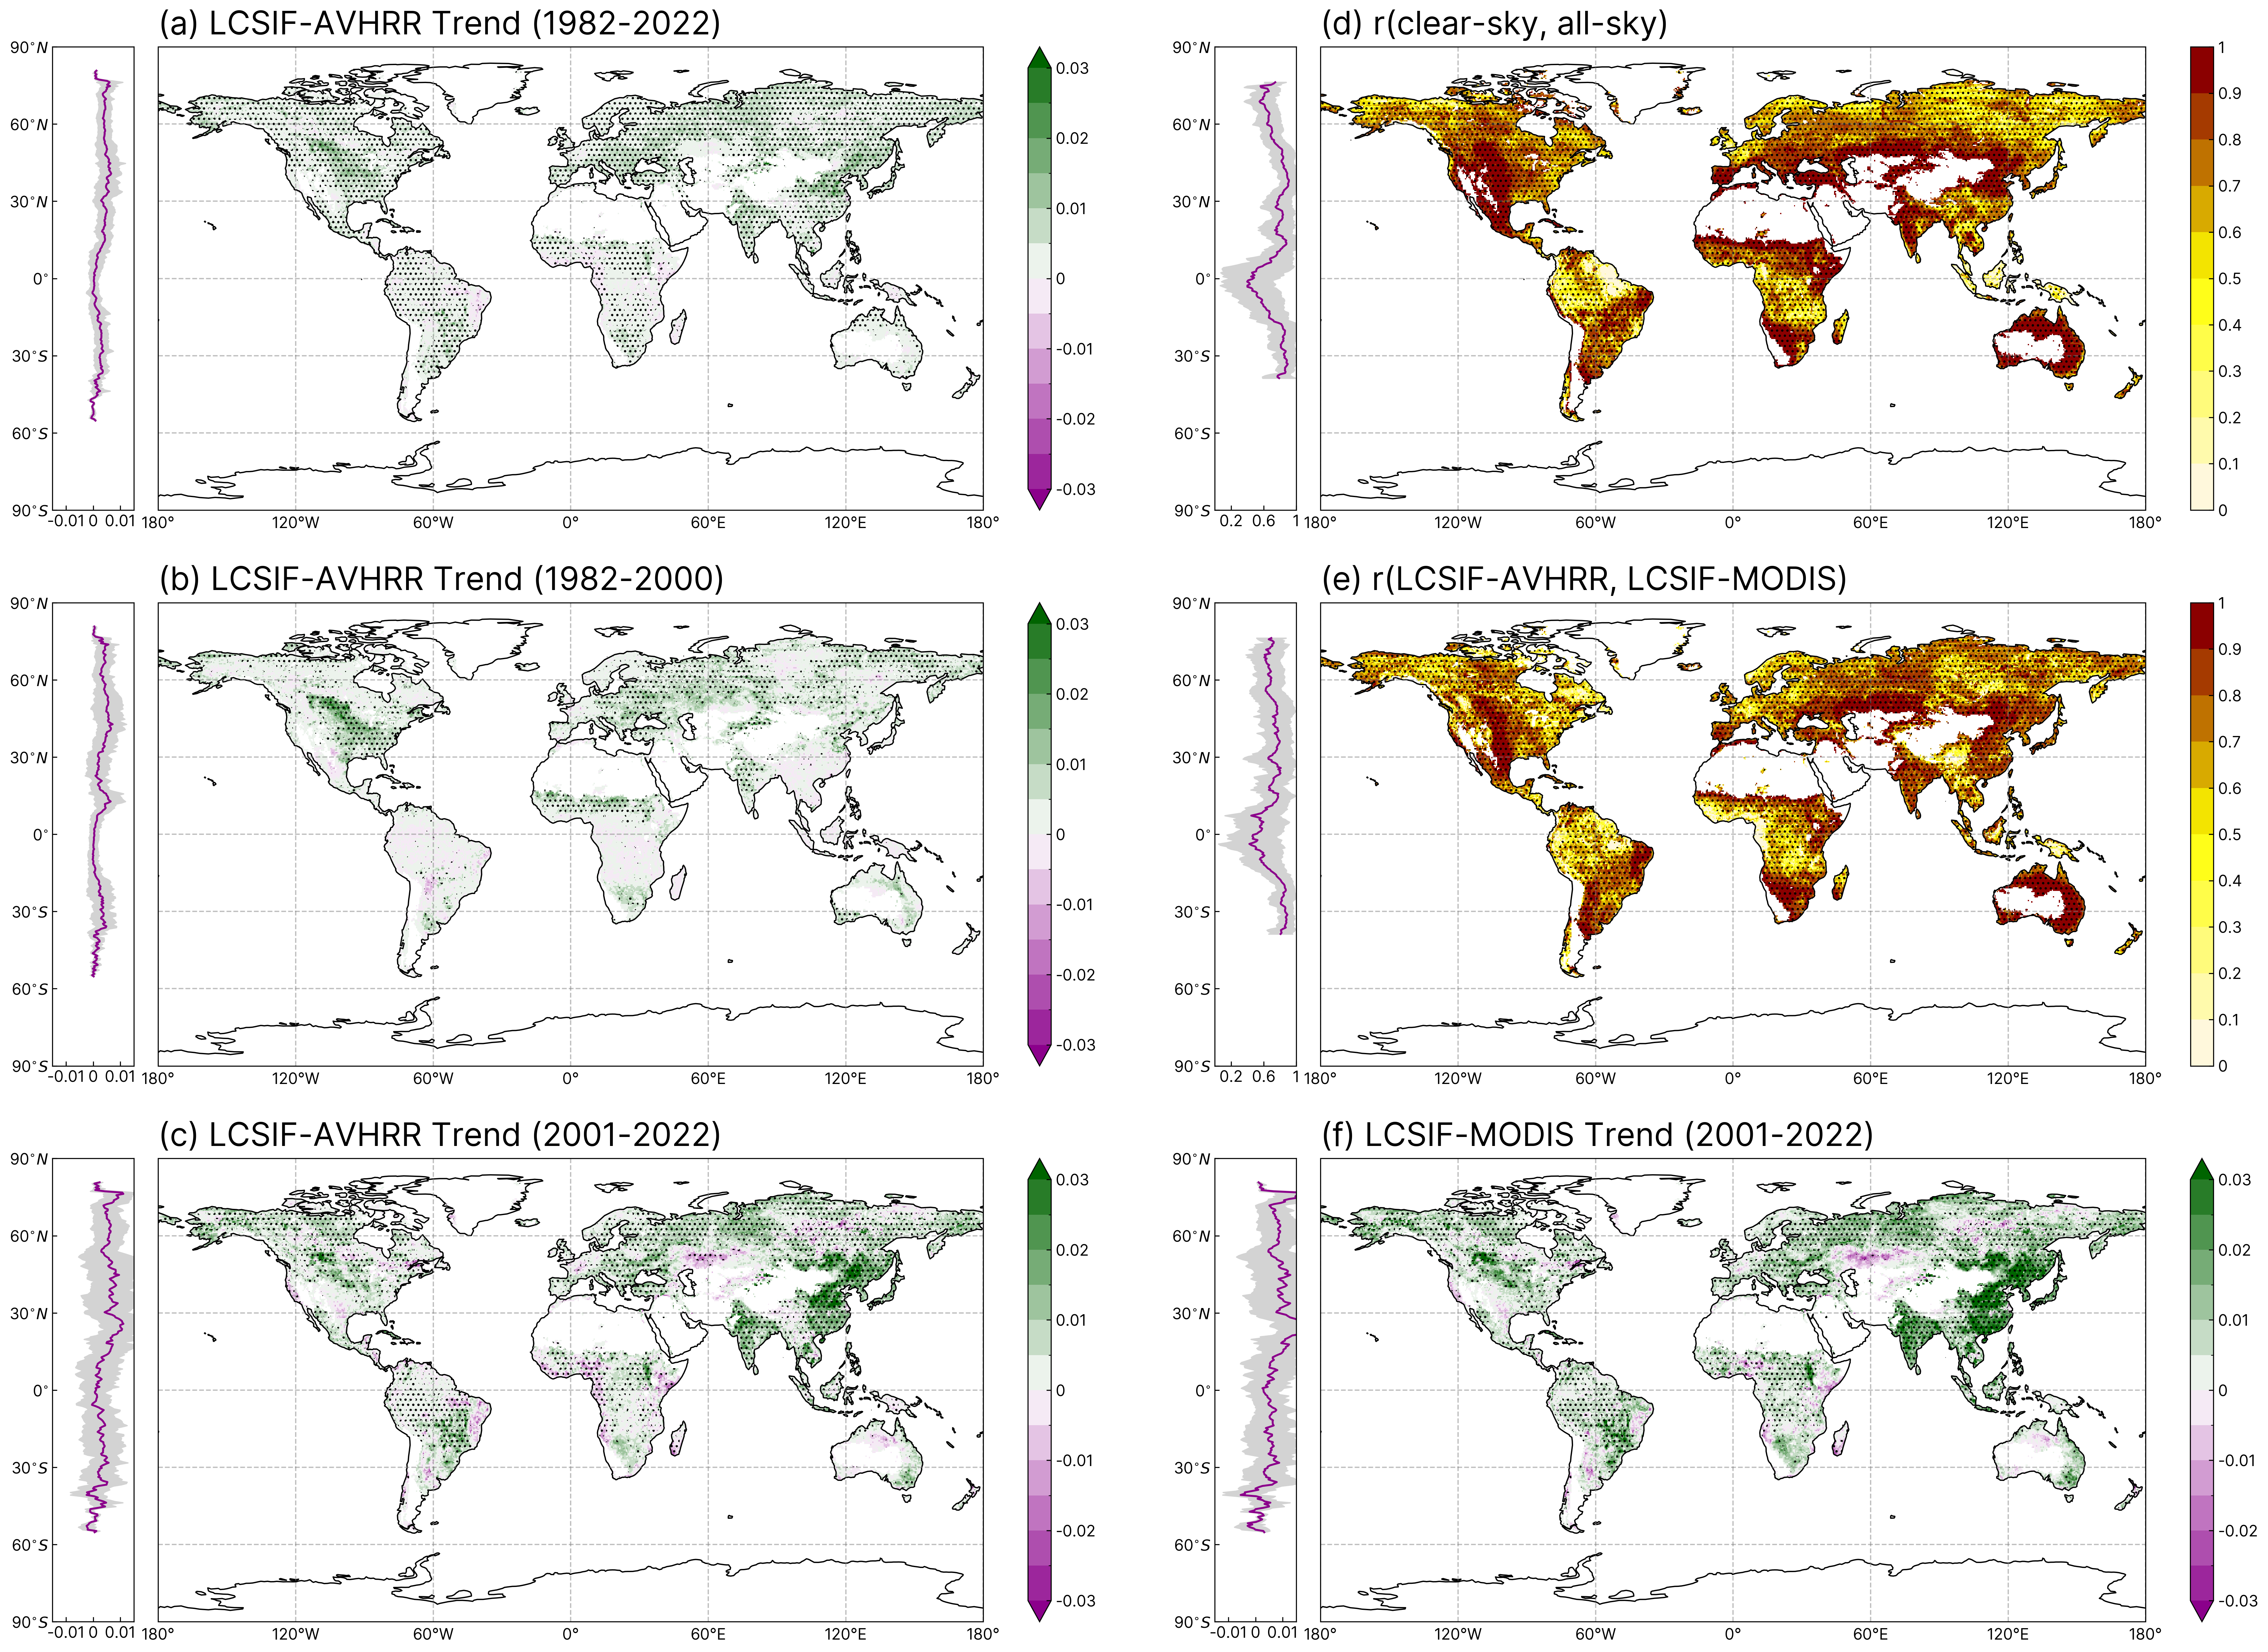

In [19]:
from matplotlib import gridspec
f = plt.figure(figsize=(25,22), dpi=300)
gs1 = gridspec.GridSpec(3, 2, width_ratios=[0.2, 2.2],
                       height_ratios=[1, 1, 1], wspace=0.02)
gs1.update(left=0.05, right=0.48, wspace=0.05)

ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1], projection=ccrs.PlateCarree())
ax3 = plt.subplot(gs1[1, 0])
ax4 = plt.subplot(gs1[1, 1], projection=ccrs.PlateCarree())
ax5 = plt.subplot(gs1[2, 0])
ax6 = plt.subplot(gs1[2, 1], projection=ccrs.PlateCarree())

gs2 = gridspec.GridSpec(3, 2, width_ratios=[0.2, 2.2],
                       height_ratios=[1, 1, 1], wspace=0.02)
gs2.update(left=0.55, right=0.98, wspace=0.05)


ax7 = plt.subplot(gs2[0, 0])
ax8 = plt.subplot(gs2[0, 1], projection=ccrs.PlateCarree())
ax9 = plt.subplot(gs2[1, 0])
ax10 = plt.subplot(gs2[1, 1], projection=ccrs.PlateCarree())
ax11 = plt.subplot(gs2[2, 0])
ax12 = plt.subplot(gs2[2, 1], projection=ccrs.PlateCarree())

plot_pattern(f, ax1, ax2, lcsif_slope_copy, lcsif_pval_copy, "(a) LCSIF-AVHRR Trend (1982-2022)")
plot_pattern(f, ax3, ax4, sif_v31_pre_2001_slope_copy, sif_v31_pre_2001_pval_copy, "(b) LCSIF-AVHRR Trend (1982-2000)")
plot_pattern(f, ax5, ax6, sif_v31_post_2001_slope_copy, sif_v31_post_2001_pval_copy, "(c) LCSIF-AVHRR Trend (2001-2022)")
plot_pattern(f, ax7, ax8, clear_all_cor_copy, clear_all_pval.values, "(d) r(clear-sky, all-sky)", True)
plot_pattern(f, ax9, ax10, avhrr_modis_cor_copy, avhrr_modis_pval.values, "(e) r(LCSIF-AVHRR, LCSIF-MODIS)", True)
plot_pattern(f, ax11, ax12, modis_slope_copy, modis_pval_copy, "(f) LCSIF-MODIS Trend (2001-2022) ")

plt.savefig("sif_trend_spatial_nan_max_km_snow_3.1.png", dpi=300)
